# Лабораторная работа № 4.1
## "Определение энергии $\alpha$-частиц по величине их пробега в воздухе"

Измеряется пробег $\alpha$-частиц в воздухе двумя способами $-$ с помощью торцевого счетчика Гейгера и сцинтилляционного счетчика, $-$ и по полученным величинам определяется их энергия.

In [1]:
WORKING_DIRECTORY = 'alekseik1-642'
RA_FILE = 'radium.csv'
U_FILE = 'uran.csv'
PU_FILE = 'pu.csv'
AM_TH_FILE = 'Am+Th.csv'
# TODO: поменяйте на свой
HEADER_NUMBER = 21

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc

In [23]:
def read_table_and_time(path):
    df = pd.read_csv(
        path, 
        delimiter=';')
    # Найдем время
    time = df[df['Unnamed: 0'] == 'LTime'].iloc[-1, 1]
    # Возьмем нужные данные
    ind = df[df['Unnamed: 0'] == 'Channel'].index[0]
    df.columns = df.iloc[ind]
    df = df.iloc[ind+1:]
    # Обнулим индексы
    df.reset_index(drop=True, inplace=True)
    # Приведем к численному типу
    df = df.apply(pd.to_numeric)
    return df, float(time)

### Градуировка по $_{\phantom{2}88}^{226}Ra$

In [24]:
ra_df, ra_time = read_table_and_time(os.path.join(WORKING_DIRECTORY, 
                                                  RA_FILE))
ra_df.head()

20,Channel,Value
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


Построим ориентировочный график зависимости $N(E) = a\,E$

In [25]:
x_values = ra_df['Channel']
y_values = ra_df['Value']
#plt.plot(x_values, y_values)
#plt.show()

In [99]:
def plot_data_optimized(x_values, y_values, 
                        title=r'Graph', x_label=r'X', y_label=r'Y', 
                        save_to=False, threshold=0.01):
    '''
    Умное построение:
    1) Убираются данные, похожие на шум (те, чье значение < 1% от максимального)
    '''
    fig, axes = plt.subplots(figsize=(16, 9))
    
    max_y, min_y = np.max(y_values), np.min(y_values)
    threshold *= (max_y-min_y)
    x_values, y_values = (x_values[y_values >= threshold], 
                          y_values[y_values >= threshold])
    
    axes.plot(x_values, y_values)
    axes.grid(True)
    axes.set_xlabel(x_label)
    axes.set_ylabel(y_label)
    axes.set_title(title)
    # Сохраним
    if save_to:
        fig.savefig(save_to)
    fig.show()

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


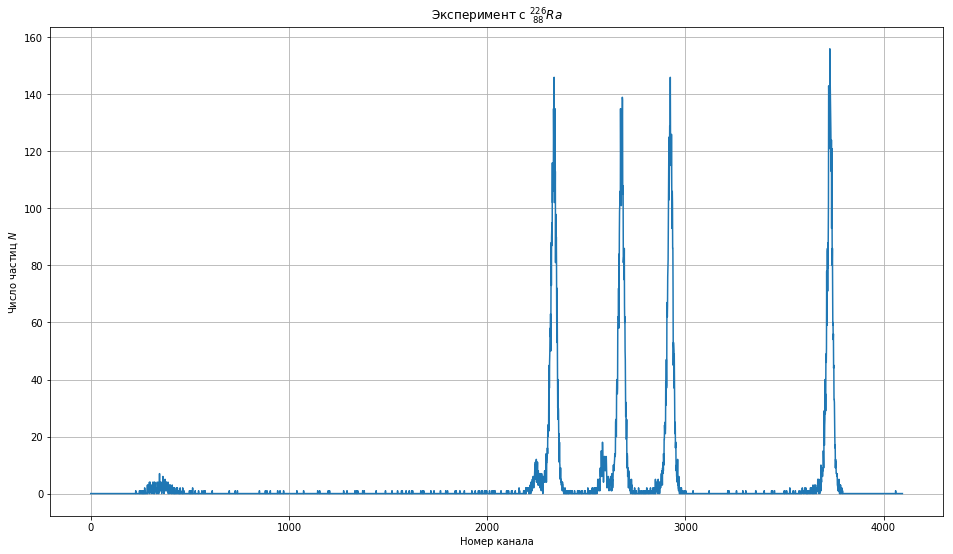

In [100]:
plot_data_optimized(x_values=x_values, y_values=y_values, threshold=0,
                    title=r'Эксперимент с $^{226}_{\,\,88}Ra$', 
                    x_label=r'Номер канала', y_label=r'Число частиц $N$',
                    save_to='out1.pdf')

Попытаемся аппросимировать пики гауссианой